In [1]:
import pandas as pd
import numpy as np
import time
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler

%matplotlib inline

## PCA

In [2]:
t0 = time.time()
df = pd.read_csv("./data/mRNA_lognorm_MinMaxScaled.csv", 
                 index_col="sample_id")
print("loading matrix takes {0} seconds".format(time.time()-t0))

loading matrix takes 88.2619194984436 seconds


In [3]:
pca = PCA()
t0 = time.time()
pca.fit(df)
print("fitting PCA to this matrix takes {0} seconds".format(time.time()-t0))

fitting PCA to this matrix takes 699.3507599830627 seconds


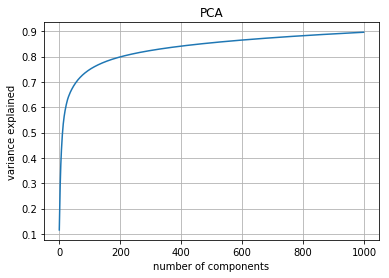

In [4]:
plt.plot(np.cumsum(pca.explained_variance_ratio_)[:1000])
plt.ylabel("variance explained")
plt.title("PCA")
plt.grid()
plt.xlabel("number of components")

In [6]:
# get number of components where 60%, 70%, 80% and 90% of of variations are preserved
def get_n_component_for_x_variance(x, variance_list):
    for i, variance in enumerate(variance_list):
        if variance > x:
            return i 
variance_preserved = np.cumsum(pca.explained_variance_ratio_)

variance_dict = {}
for variance in [0.6,0.7,0.8,0.9]:
    variance_dict[variance] = get_n_component_for_x_variance(variance, variance_preserved)
print(variance_dict)

{0.6: 22, 0.7: 57, 0.8: 205, 0.9: 1070}


In [8]:
X_tranformed = pca.transform(df)

In [9]:
for variance, n in variance_dict.items():
    df_PCA = pd.DataFrame(X_tranformed[:, :n], index=df.index)
    df_PCA.to_csv("./data/mRNA_PCA_{0}_variance.csv".format(variance))

### Histogram of PCA processed data

variance=0.6, n_components=22


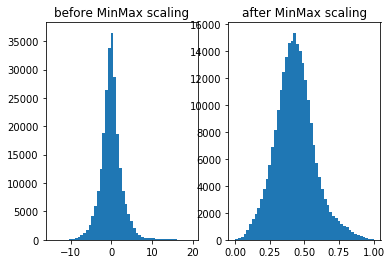

variance=0.7, n_components=57


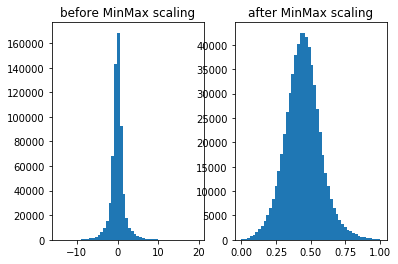

variance=0.8, n_components=205


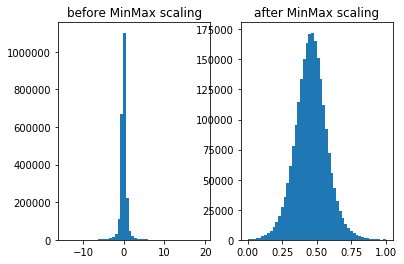

variance=0.9, n_components=1070


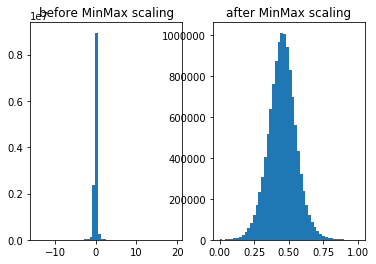

In [23]:
for variance, n in variance_dict.items():
    print("variance={0}, n_components={1}".format(variance, n))
    df= pd.read_csv("./data/mRNA_PCA_{0}_variance.csv".format(variance), 
                    index_col="sample_id")
    scaler = MinMaxScaler()
    X_transform = scaler.fit_transform(df)
    f, axes = plt.subplots(1, 2)
    axes[0].hist(df.as_matrix().flatten(), bins=50)
    axes[0].set_title("before MinMax scaling")
    axes[1].hist(X_transform.flatten(), bins=50)
    axes[1].set_title("after MinMax scaling")
    plt.show()
    
    # saved transformed PCA results
    df_scaled = pd.DataFrame(X_transform, index=df.index, columns=df.columns)
    df_scaled.to_csv("./data/mRNA_PCA_{0}_variance_MinMaxScaled.csv".format(variance))